<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# установка модулей
# !pip install -Uq scikit-learn
# !pip install catboost
# !pip install lightgbm

In [2]:
# импорт библиотеки
import os
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from time import time


from sklearn.model_selection import train_test_split,RandomizedSearchCV,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment=None

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

In [4]:

path = 'https://code.s3.yandex.net/datasets/taxi.csv'
taxi_df = pd.read_csv(path,index_col=[0],parse_dates=[0])
taxi_df.sort_index(inplace=True)


In [5]:
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
taxi_df.index.is_monotonic

True

In [8]:
taxi_df.isna().sum()

num_orders    0
dtype: int64

In [9]:
#Ресемплирование по одному часу
taxi_df=taxi_df.resample('1H').sum()

In [10]:
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<b>Вывод</b>

- Данные соответствуют по описанию задачи.
- Проверена наличие пропущенных значений их нет.
- Дата и время расположена в хронологическом порядке.
- Ресемплировали данные по одному часу.

## Анализ

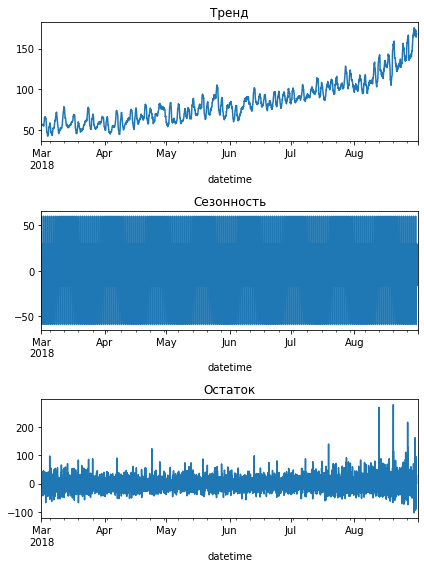

In [11]:
#Восползуемся код с тренажера для графиков

decomposed =seasonal_decompose(taxi_df)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

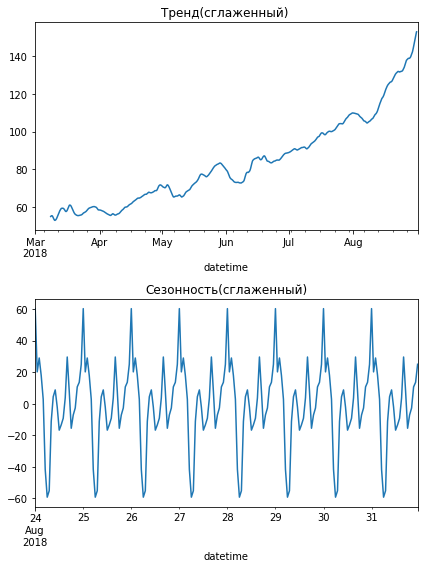

In [12]:
#Посмотрим графиков сглаженный тренд и сезонность

plt.figure(figsize=(6, 8))

plt.subplot(211)
decomposed.trend.rolling(168).mean().plot(ax=plt.gca())
plt.title('Тренд(сглаженный) ')

plt.subplot(212)
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность(сглаженный)')
plt.tight_layout()


<b>Вывод</b>

- Наблюдается рост тренда.
- Также наблюдаем сезонность: увелечивает заказов утром, к вечером достигает свой максимум и ночью уменьшается.


## Обучение

<Figure size 720x432 with 0 Axes>

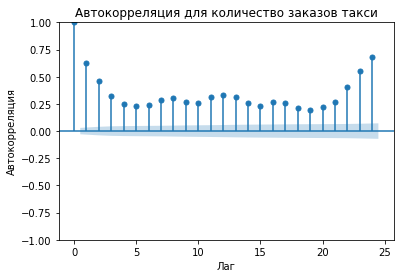

In [13]:
# Построим графика автокорреляции
plt.figure(figsize=(10, 6))
plot_acf(taxi_df, lags=24)  # Построим ACF для первых 24 лагов
plt.title('Автокорреляция для количество заказов такси')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.show()

<b>Вывод</b>

- На графике можно заметить пики корреляции при лагах, кратных 24


In [14]:
#Создаем признаки восползуемся код с тренажера

def make_features(data, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in [1,24]:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    return data

<font color='blue'><b>Теория </b></font> ❌\
<font color='red'><s>На мой взгляд: не все признаки подходят, чисто логически. Выскажу свою позицию:<br>

<font color='red'>1) Признак месяц: НЕТ, не подходит, у нас в истории всего один март, май... И данных меньше чем за год. Да и горизонт прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.</font><br>
<font color='darkorange'>2) Признак день: НЕТ, также не подходит, у нас нет сезонности внутри месяца, будет просто последовательность чисел.</s><br></font>
<font color='green'>3) Признак день недели: ДА, т.к. у нас есть недельная сезонность.<br>
4) Признак час: ДА, т.к. есть часовая (суточная) сезонность.<br>
5) Признак lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
6) Признак rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда.</font> <br>

<font color='blue'>Как ты думаешь?</font>

In [15]:

taxi_df=make_features(taxi_df,24)

In [16]:
taxi_df.head()

,num_orders,dayofweek,hour,lag_1,lag_24,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,124.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,85.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,71.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,43.0,56.958333


In [17]:
#Разбываем датасет
train, test = train_test_split(taxi_df, shuffle=False, test_size = TEST_SIZE,  random_state = RANDOM_STATE)
X_train,y_train=train.drop(['num_orders'],axis=1),train['num_orders']
X_test,y_test=test.drop(['num_orders'],axis=1),test['num_orders']

### LinearRegression

In [18]:
model_lr = LinearRegression()
param_grid_lr ={}
tss = TimeSeriesSplit(n_splits=2)

randomized_search_lr = RandomizedSearchCV(
    model_lr, 
    param_grid_lr, 
    cv=tss,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', (randomized_search_lr.best_score_)*-1)

Лучшая модель и её параметры:

 LinearRegression()
Метрика лучшей модели на тренировочной выборке: 28.96917747525734


In [19]:
#замеряем время обучения
start = time()
    
b_lr=randomized_search_lr.best_estimator_
best_lr = b_lr.fit(X_train, y_train)

end = time()
lr_model_time = end-start

print(f'Время обучения модели LinearRegression: {lr_model_time:.1f}s')

Время обучения модели LinearRegression: 0.1s


In [20]:
#замеряем время предсказания
start = time()
    
y_pred = best_lr.predict(X_train)
end = time()
lr_model_predict_time = end-start
print(f'Время предсказания модели LinearRegression: {lr_model_predict_time:.1f}s')


Время предсказания модели LinearRegression: 0.0s


### CatBoostRegressor

In [21]:
model_cb = CatBoostRegressor(random_state=RANDOM_STATE)
param_grid_cb = {
        'max_depth': [5, 10],
        'iterations': [100, 500]}

randomized_search_cb = RandomizedSearchCV(
    model_cb, 
    param_grid_cb, 
    cv=tss,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_cb.fit(X_train, y_train)


Learning rate set to 0.278052
0:	learn: 26.9277173	total: 46.9ms	remaining: 4.65s
1:	learn: 24.5273749	total: 47.8ms	remaining: 2.34s
2:	learn: 23.0220016	total: 48.4ms	remaining: 1.56s
3:	learn: 21.9021077	total: 49.2ms	remaining: 1.18s
4:	learn: 21.1959405	total: 49.7ms	remaining: 945ms
5:	learn: 20.4378747	total: 50.3ms	remaining: 789ms
6:	learn: 20.0092737	total: 51ms	remaining: 677ms
7:	learn: 19.6939095	total: 51.7ms	remaining: 594ms
8:	learn: 19.3817263	total: 52.2ms	remaining: 528ms
9:	learn: 19.2599506	total: 52.8ms	remaining: 475ms
10:	learn: 19.0054974	total: 53.4ms	remaining: 432ms
11:	learn: 18.7759341	total: 54ms	remaining: 396ms
12:	learn: 18.4990109	total: 66.2ms	remaining: 443ms
13:	learn: 18.3069059	total: 66.9ms	remaining: 411ms
14:	learn: 18.1895137	total: 67.5ms	remaining: 383ms
15:	learn: 18.0972369	total: 68.2ms	remaining: 358ms
16:	learn: 18.0572269	total: 68.8ms	remaining: 336ms
17:	learn: 17.8169982	total: 69.4ms	remaining: 316ms
18:	learn: 17.6751094	total: 7

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fd68d652ca0>,
                   n_jobs=-1,
                   param_distributions={'iterations': [100, 500],
                                        'max_depth': [5, 10]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [22]:
print('Лучшая модель и её параметры:\n\n', randomized_search_cb.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', (randomized_search_cb.best_score_)*-1)


Лучшая модель и её параметры:

Метрика лучшей модели на тренировочной выборке: 27.799154020122387


In [23]:
#замеряем время обучения
start = time()
    
m_cb=randomized_search_cb.best_estimator_
best_cb = m_cb.fit(X_train, y_train)

end = time()
cb_model_time = end-start

print(f'Время обучения модели CatBoostRegressor: {cb_model_time:.1f}s')

Learning rate set to 0.330732
0:	learn: 33.0420434	total: 1.06ms	remaining: 105ms
1:	learn: 29.8531972	total: 2.18ms	remaining: 107ms
2:	learn: 27.8180208	total: 3.07ms	remaining: 99.2ms
3:	learn: 26.5335339	total: 3.93ms	remaining: 94.4ms
4:	learn: 25.7613387	total: 4.84ms	remaining: 92ms
5:	learn: 25.1659336	total: 5.77ms	remaining: 90.4ms
6:	learn: 24.8518175	total: 6.63ms	remaining: 88.1ms
7:	learn: 24.5747457	total: 7.46ms	remaining: 85.8ms
8:	learn: 24.4080087	total: 8.4ms	remaining: 84.9ms
9:	learn: 23.9369537	total: 9.28ms	remaining: 83.5ms
10:	learn: 23.7844222	total: 10.1ms	remaining: 82ms
11:	learn: 23.4186622	total: 11.1ms	remaining: 81.7ms
12:	learn: 23.3189922	total: 12ms	remaining: 80.4ms
13:	learn: 23.2218152	total: 12.9ms	remaining: 79.1ms
14:	learn: 23.1364608	total: 13.7ms	remaining: 77.6ms
15:	learn: 23.0702161	total: 14.8ms	remaining: 77.9ms
16:	learn: 23.0323068	total: 15.8ms	remaining: 77.1ms
17:	learn: 22.8227269	total: 16.8ms	remaining: 76.5ms
18:	learn: 22.603

In [24]:
#замеряем время предсказания
start = time()
    
y_pred = best_cb.predict(X_train)
end = time()
cb_model_predict_time = end-start
print(f'Время предсказания модели CatBoostRegressor: {cb_model_predict_time:.1f}s')


Время предсказания модели CatBoostRegressor: 0.0s


### LGBMRegressor

In [26]:
model_lgb = LGBMRegressor(random_state=RANDOM_STATE, num_threads = 4)

param_grid_lgb ={
        'max_depth': [8, 15],
        'n_estimators': [500,1000]
    }

randomized_search_lgb = RandomizedSearchCV(
    model_lgb, 
    param_grid_lgb, 
    cv=tss,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lgb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lgb.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', (randomized_search_lgb.best_score_)*-1)

[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
Лучшая модель и её параметры:

 LGBMRegressor(max_depth=15, n_estimators=500, num_threads=4, random_state=42)
Метрика лучшей модели на тренировочной выборке: 29.019940586539704


In [27]:
#замеряем время обучения
start = time()
    
l_lgb=randomized_search_lgb.best_estimator_
best_lgb = l_lgb.fit(X_train, y_train)

end = time()
lgb_model_time = end-start

print(f'Время обучения модели LGBMRegressor: {lgb_model_time:.1f}s')

Время обучения модели LGBMRegressor: 2.3s


In [28]:
#замеряем время предсказания
start = time()
    
y_pred = best_lgb.predict(X_train)

end = time()
lgb_model_predict_time = end-start
print(f'Время предсказания модели LGBMRegressor: {lgb_model_predict_time:.1f}s')

Время предсказания модели LGBMRegressor: 0.3s


<b>Вывод</b>

- Создали новые признаки.
- Обучили разные модели с различными гиперпараметрами.


## Тестирование

**LinearRegression**

In [29]:
print(f'Время обучения: {lr_model_time:.1f}s')
print(f'Время предсказания: {lr_model_predict_time:.1f}s')
print(f'LinearRegression метрика RMSE на тренировочной выборке: {(randomized_search_lr.best_score_)*-1:.1f}')

Время обучения: 0.1s
Время предсказания: 0.0s
LinearRegression метрика RMSE на тренировочной выборке: 29.0


**CatBoostRegressor**

In [30]:
print(f'Время обучения: {cb_model_time:.1f}s')
print(f'Время предсказания: {cb_model_predict_time:.1f}s')
print(f'CatBoostRegressor метрика RMSE на тренировочной выборке: {(randomized_search_cb.best_score_)*-1:.1f}')


Время обучения: 0.7s
Время предсказания: 0.0s
CatBoostRegressor метрика RMSE на тренировочной выборке: 27.8


**LGBMRegressor**

In [31]:
print(f'Время обучения: {lgb_model_time:.1f}s')
print(f'Время предсказания: {lgb_model_predict_time:.1f}s')
print(f'LGBMRegressor метрика RMSE на тренировочной выборке: {(randomized_search_lgb.best_score_)*-1:.1f}')


Время обучения: 2.3s
Время предсказания: 0.3s
LGBMRegressor метрика RMSE на тренировочной выборке: 29.0


In [32]:
print("Лучшая модель и её параметры:", best_cb.get_params())

Лучшая модель и её параметры: {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 5, 'iterations': 100}


<b>Вывод</b>

- Лучшая модель CatBoostRegressor с параметрамы {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 5, 'iterations': 100} .


In [33]:
#Качество модели на тестовой выборке
y_predt = best_cb.predict(X_test)
rmse_cb_test=root_mean_squared_error(y_test, y_predt)
print(f'CatBoostRegressor метрика RMSE : {rmse_cb_test:.1f}')

CatBoostRegressor метрика RMSE : 43.0


<b>Вывод</b>

- Критерий успеха выполнено на тестовой выборке rmse_score меньше 48.


## Общий вывод

- Разработали модель машинного обучения, которая прогнозирует количество заказов такси на следующий час.

- Провели предобработку данных: Сортировали по индексу и ресемпировали данные по одному часу.

- Для поиска лучшего моделя использовали пайплан с гиперпараметрами модели LinearRegression() и два бустинга LGBMRegressor, CatBoostregressor и поиска лучшего параметра RandomizedSearchCV.

- Лучшая модель CatBoostRegressor с параметрамы {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 5, 'iterations': 100} и метрика на тесте rmse_score=44.5 .

- Худшая модель оказалось LinearRegression() .

- По время обучения и по метрика rmse_score  на тренировочной выборке  лучшая модель CatBoostRegressor.

- Рекомендую использовать для прогнозирования количество заказов такси на следующий час  модель CatBoostRegressor с параметрамы {'loss_function': 'RMSE', 'random_state': 42, 'max_depth': 5, 'iterations': 100} .



<font color='green'>Дополнительные материалы:\
Е.Рябенко - Прогнозирование временных рядов https://www.youtube.com/watch?v=u433nrxdf5k \
Б.Б. Демешев - временные ряды https://disk.yandex.ru/i/LiDHB-B3A6Lz5A \
Канторович - Анализ временных рядов https://yadi.sk/i/IOkUOS3hTXf3gg \

Базовое применение ARIMA - https://colab.research.google.com/drive/17RnG91Eq8JBKyxToNzvCvjibfxum-oPj?usp=sharing \
Prophet модель от известной компании https://facebook.github.io/prophet/ \
https://facebook.github.io/prophet/docs/quick_start.html#python-api \
https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb \
Или [Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habr.com/ru/company/ods/blog/323730/)
</font>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48